In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from functools import partial 

from pathlib import Path

%run ../lib.py 


### Equations:

$a_x = -\frac{F_d \cdot v_x}{m \cdot v} $

$a_y = -g - \frac{F_d \cdot v_y}{m \cdot v}$


### Variables and Constants:

- $ v_x $: The velocity component in the $x$-direction.
- $ v_y $: The velocity component in the $y$-direction.
- $ F_d $: The drag force acting on the object.
- $ m $: The mass of the object.
- $ v $: The magnitude of the velocity vector, which is calculated as $v = \sqrt{v_x^2 + v_y^2}$.
- $ g $: The acceleration due to gravity.

### Explanation:

1. **Drag Force**:
   - The drag force $F_d$ is a resistive force that acts opposite to the direction of motion. It tends to slow down the object.
   - The drag force is often proportional to the square of the velocity of the object, and it acts in the direction opposite to the velocity vector.

2. **Acceleration in the $x$-Direction ($a_x$)**:
   - The term $-\frac{F_d \cdot v_x}{m \cdot v}$ represents the deceleration due to the drag force in the $x$-direction.
   - The drag force component in the $x$-direction is $F_d \cdot \frac{v_x}{v}$. Here, $\frac{v_x}{v}$ is the cosine of the angle between the velocity vector and the $x$-axis.
   - Dividing by the mass $m$ converts the force to acceleration.
   - The minus sign indicates that this acceleration acts opposite to the direction of the velocity component $v_x$.

3. **Acceleration in the $y$-Direction ($a_y$)**:
   - The term $-g$ represents the constant downward acceleration due to gravity.
   - The term $-\frac{F_d \cdot v_y}{m \cdot v}$ represents the deceleration due to the drag force in the $y$-direction.
   - The drag force component in the $y$-direction is $F_d \cdot \frac{v_y}{v}$. Here, $\frac{v_y}{v}$ is the sine of the angle between the velocity vector and the $y$-axis.
   - Dividing by the mass $m$ converts the force to acceleration.
   - The minus sign indicates that this acceleration acts opposite to the direction of the velocity component $v_y$.

### Summary:

- The acceleration in the $x$-direction ($a_x$) is due solely to the drag force acting opposite to the $x$-component of the velocity.
- The acceleration in the $y$-direction ($a_y$) is due to both gravity (acting downward) and the drag force acting opposite to the $y$-component of the velocity.

These equations encapsulate how the object’s velocity changes over time due to the opposing forces of drag and gravity.

3.333333333333333

In [21]:
def plot_traj(df):
    
    # Plot y vs x
    plt.figure(figsize=(5, 3.33))
    plt.plot(df['x'], df['y'], label='Projectile Path')
    plt.xlabel('x (meters)')
    plt.ylabel('y (meters)')
    plt.ylim(0,180)
    plt.xlim(0,270)
    plt.title('Projectile Motion: y vs x')
    plt.legend()
    plt.grid(True)
    plt.show()


985


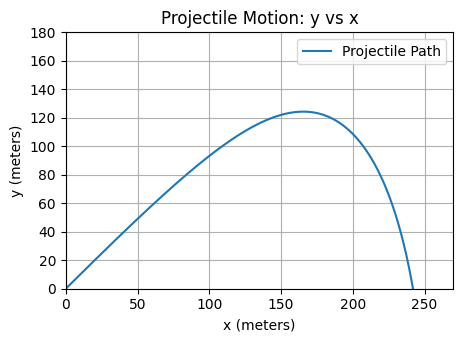

In [24]:

# Constants


g = 9.81  # Gravitational acceleration (m/s^2)
dt = 0.01  # Time step (s)

C_d = 0.047  # Drag coefficient
rho = 1.225  # Air density (kg/m^3)
A = 0.045  # Cross-sectional area (m^2)


# Event function to stop integration when y < 0
def event_y_below_zero(t, state,m , drag_f):
    return state[1]  # state[1] is y, so looking for y == 0

event_y_below_zero.terminal = True
event_y_below_zero.direction = -1 # When y == 0, look for transition from pos to neg. 


def drag(t, vx, vy):
    """Compute the drag force"""
    v = np.sqrt(vx**2 + vy**2) # Magnitude of velocity vector
    F_d = 0.5 * C_d * rho * A * v**2
    
    return F_d


def _projectile_motion( t, state, m, drag_f):
    """Calculate dy/dt for the state y. This version includes all st"""
    x, y, vx, vy = state
    
    v = np.sqrt(vx**2 + vy**2) # Magnitude of velocity vector
    
    F_d = drag_f(t, vx, vy)

    # v_x/v is the cos of the angle of the velocity vector
    # so this is -F_d*cos(v)
    ax = -F_d * vx / (m * v)

    #v_y/v is the sin of the angle of the velocity vector
    ay = -g - (F_d * vy / (m * v))
    
    return [vx, vy, ax, ay ]

def projectile_motion( t, state, m, drag_f):
    """Calculate dy/dt for the state y"""
    x, y, vx, vy = state
    
    v = np.sqrt(vx**2 + vy**2) # Magnitude of velocity vector
    
    F_d = drag_f(t, vx, vy)

    # v_x/v is the cos of the angle of the velocity vector
    # so this is -F_d*cos(v)
    ax = -F_d * vx / (m * v)

    #v_y/v is the sin of the angle of the velocity vector
    ay = -g - (F_d * vy / (m * v))
    
    return [vx, vy, ax, ay ]

def throw(v0, m, angle, drag_f):
    """Solve a trajectory for an initial velocity and angle"""
    
    angle_rad = np.radians(angle)
    
    # Initial velocity components
    vx0 = v0 * np.cos(angle_rad)
    vy0 = v0 * np.sin(angle_rad)
    
    x0 = 0    # Initial x position (m)
    y0 = 0    # Initial y position (m)
   
    # Time span
    t_max = 10
    t_span = (0, t_max)  
    t_eval = np.arange(0, t_max, dt)

    solution = solve_ivp(projectile_motion, t_span, 
                         y0 =  [x0, y0, vx0, vy0], # Initial State
                         t_eval=t_eval, 
                         args = (m, drag_f), events=event_y_below_zero)

    t = solution.t
    x, y, vx, vy = solution.y # Unpack the states
    
    # Calculate drag force and accelerations for each time step
    # We have to re-calc these b/c they are hard to pass out of projectile_motion() through solve_ivp()
    # However, note that these equations are working with vectors, not scalars like they were in 
    # projectile_motion()

    # drag_v = np.vectorize(drag)
    
    F_d = drag_f(t, vx, vy)
    
    v = np.sqrt(vx**2 + vy**2)
    ax = -F_d * vx / (m * v)
    ay = -g - (F_d * vy / (m * v))
    
    # Create a pandas DataFrame
    
    data = {
        't': t,
        'x': x,
        'y': y,
        'vx': vx,
        'vy': vy,
        'ax': ax,
        'ay': ay,
        'F_d': F_d
    }
    
    return pd.DataFrame(data)

df = throw(v0=200, m = 0.145, angle=45, drag_f=drag)
plot_traj(df)

In [2]:
df

,t,x,y,vx,vy,ax,ay,F_d
0,0.00,0.000000,0.000000,35.355339,35.355339,-15.793321,-25.603321,3.238594
1,0.01,0.352766,0.352277,35.198217,35.100335,-15.631510,-25.398040,3.200959
2,0.02,0.703970,0.702013,35.042701,34.847368,-15.472062,-25.195819,3.163886
3,0.03,1.053626,1.049231,34.888768,34.596408,-15.314933,-24.996598,3.127364
4,0.04,1.401751,1.393949,34.736394,34.347426,-15.160078,-24.800319,3.091384
...,...,...,...,...,...,...,...,...
535,5.35,103.026530,0.948348,11.029495,-21.911370,-2.417213,-5.007926,0.779540
536,5.36,103.136632,0.729297,11.005355,-21.961450,-2.415258,-4.990295,0.781697
537,5.37,103.246492,0.509751,10.981234,-22.011357,-2.413285,-4.972686,0.783853
538,5.38,103.356110,0.289710,10.957134,-22.061090,-2.411296,-4.955098,0.786007


In [25]:
v = np.array([1,2,3,4])
np.append(v, np.array([0,0]))

array([1, 2, 3, 4, 0, 0])

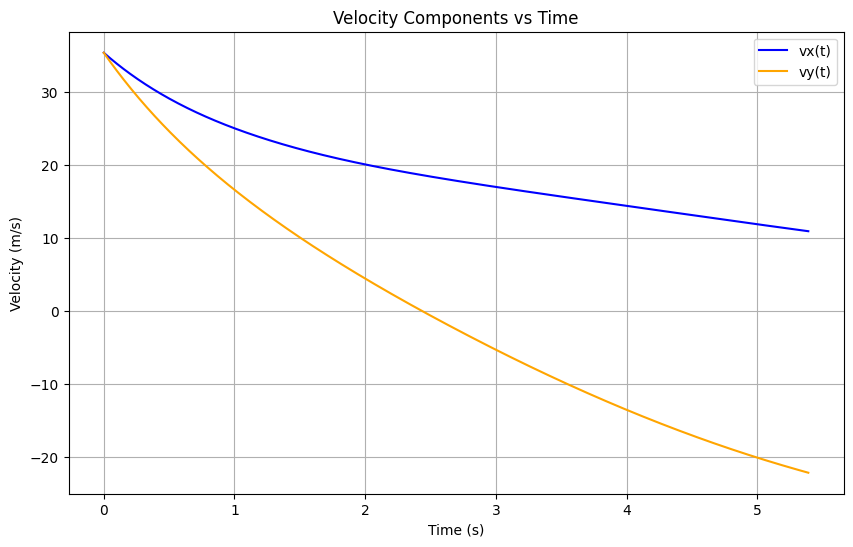

In [3]:
import matplotlib.pyplot as plt

# Plotting vx and vy versus time on the same axes
plt.figure(figsize=(10, 6))

plt.plot(df['t'], df['vx'], label='vx(t)', color='blue')
plt.plot(df['t'], df['vy'], label='vy(t)', color='orange')

plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity Components vs Time')
plt.legend()
plt.grid(True)

plt.show()


# Make a movie

May require ffmpeg:

    sudo apt-get install ffmpeg  # For Ubuntu/Debian
    brew install ffmpeg          # For macOS


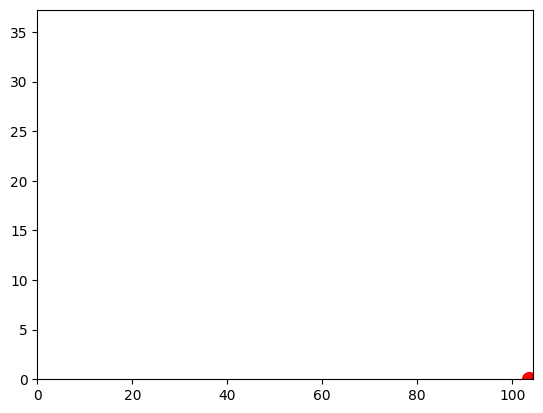

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Generate evenly spaced indices
n_frames = 100
idx = np.linspace(0, len(df) - 1, n_frames, dtype=int)
t = df.iloc[idx]

# Create the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(0, t['x'].max() + 1)
ax.set_ylim(0, t['y'].max() + 1)

# Create a red ball
ball, = ax.plot([], [], 'ro', markersize=10)

# Initialize the background of the plot
def init():
    ball.set_data([], [])
    return ball,

# Animation function
def animate(i):
  
    ball.set_data([t['x'].iloc[i]], [t['y'].iloc[i]])
    return ball,

# Create the animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=100, blit=True)

# Save the animation as an mp4 file
ani.save(vd/'ball_trajectory.mp4', writer='ffmpeg')

from IPython.display import HTML
HTML(ani.to_jshtml())